In [1]:
%matplotlib inline

# Sample reuse strategy implementation

https://hackmd.io/@cweniger/S1FJ1wafD

This is a simulation of the reuse strategy. The goal is to determine if we get the correct p(z). The simulatior is ignored for now.

P has pdf $\mathcal{N}(0, 1)$  
P' has pdf $\mathcal{U}(-1, 1)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import truncnorm, uniform

from typing import Callable, Union

float_type = Union[float,np.float64]

In [3]:
a = -1
b = 1

p = truncnorm(a, b)
pp = uniform(loc=a, scale=b-a)

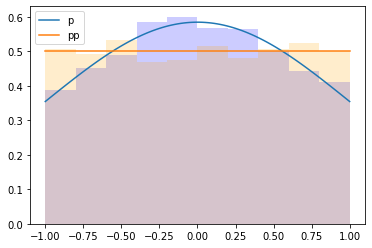

In [4]:
fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, p.pdf(x), label='p')
ax.plot(x, pp.pdf(x), label='pp')
ax.hist(p.rvs(10000), density=True, alpha=0.2, color='blue')
ax.hist(pp.rvs(10000), density=True, alpha=0.2, color='orange')
ax.legend()

fig.show()

In [5]:
def get_pdf_max(pdf: Callable[[int], np.ndarray], a: float_type, b: float_type) -> float_type:
    x = np.linspace(a, b, 100)
    return pdf(x).max()

def draw_w(maximum: float_type) -> float_type:
    return np.random.rand() * maximum

def accept_reject(zp, zpp, p_pdf, pp_pdf, pp_maximum):
    """zp ~ P(z), zpp ~ P'(z), p_pdf = P, pp_pdf = P', pp_maximum = max P'"""
    w = draw_w(pp_maximum)
    if pp_pdf(zp) >= w:
        return zpp
    else:
        return zp

In [6]:
pp_max = get_pdf_max(pp.pdf, a, b)

zs = []
for _ in range(10000):
    zp = p.rvs()
    zpp = pp.rvs()
    z = accept_reject(zp, zpp, p.pdf, pp.pdf, pp_max)
    zs.append(z)

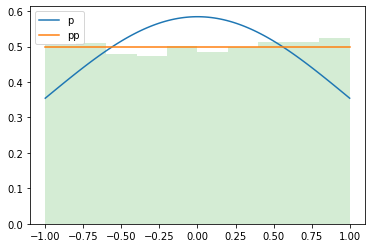

In [7]:
fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, p.pdf(x), label='p')
ax.plot(x, pp.pdf(x), label='pp')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

### What's wrong?

Obviously there is something wrong above because we are just sampling from P'. When I attempt to fix the error by replacing which distibution is compared with w, I get something closer but still not perfect.

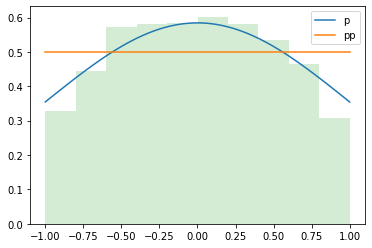

In [8]:
def accept_reject_fix_attempt(zp, zpp, p_pdf, pp_pdf, pp_maximum):
    """zp ~ P(z), zpp ~ P'(z), p_pdf = P, pp_pdf = P', pp_maximum = max P'"""
    w = draw_w(pp_maximum)
    if p_pdf(zp) <= w:
        return zpp
    else:
        return zp

pp_max = get_pdf_max(pp.pdf, a, b)

zs = []
for _ in range(10000):
    zp = p.rvs()
    zpp = pp.rvs()
    z = accept_reject_fix_attempt(zp, zpp, p.pdf, pp.pdf, pp_max)
    zs.append(z)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, p.pdf(x), label='p')
ax.plot(x, pp.pdf(x), label='pp')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

# General rejection sampling

Let's see if implementing regular rejection sampling would give any insight.  
https://en.wikipedia.org/wiki/Rejection_sampling#Algorithm

In [9]:
def rejection_sample(
    y: np.ndarray,
    f: Callable[[np.ndarray], np.ndarray], 
    g: Callable[[np.ndarray], np.ndarray], 
    m: float_type,
) -> np.ndarray:
    """Parallel implementation, f & g must have shape signature [n, ...] -> [n]."""
    n, *_ = y.shape
    u = np.random.rand(n)
    indices_to_keep = np.less(u, f(y) / (m * g(y)))
    return y[indices_to_keep, ...]

In [10]:
a = -1
b = 1

X = truncnorm(a, b)
Y = uniform(loc=a, scale=b-a)

z = np.linspace(a, b, 1000)
f_max = X.pdf(z).max()
g_min = Y.pdf(z).min()
m = f_max / g_min + 1e-6
print(m)

1.1687375489747203


8575


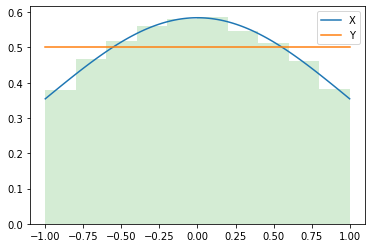

In [11]:
zs = rejection_sample(Y.rvs(10000), X.pdf, Y.pdf, m)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, X.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

print(len(zs))

Clearly this is working much better. We now test the hypothesis that the problem is the choice of m. What happens when we choose m = 1, i.e. m is too small?

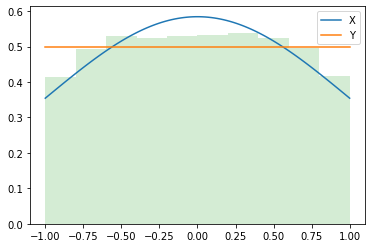

In [12]:
zs = rejection_sample(Y.rvs(100000), X.pdf, Y.pdf, 1)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, X.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

That doesn't look like what's going wrong in our algorithm.

What happens when we choose an m which is too high?

16355


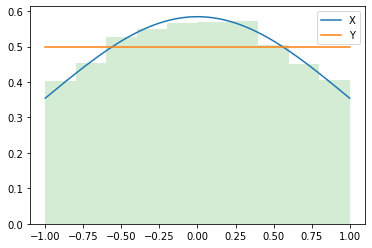

In [13]:
zs = rejection_sample(Y.rvs(100000), X.pdf, Y.pdf, m + 5)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, X.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

print(len(zs))

Note that we had to take 10x more samples, but it also converged. Therefore the problem lies somewhere else.

If we consider what we're doing in our algorithm, we actually can sample from both distributions, it's just that we want to sample from another one a few times. That's different than regular rejection sampling where we want to always sample from Y to get samples distributed like X.

Let's consider the case where we do rejection sampling, but everytime something is rejected, we just sample from the real distribution we want. This should be the same thing as we are doing in our algorithm, in principle. If it works here, then we know there is something wrong about our algorithm

In [14]:
def rejection_sample_resample_failures(
    y: np.ndarray,
    f: Callable[[np.ndarray], np.ndarray], 
    g: Callable[[np.ndarray], np.ndarray], 
    m: float_type,
    x_sampler: Callable[[int], np.ndarray],
) -> np.ndarray:
    """Parallel implementation, f & g must have shape signature [n, ...] -> [n]."""
    n, *_ = y.shape
    u = np.random.rand(n)
    indices_to_keep = np.less(u, f(y) / (m * g(y)))
    retained_y = y[indices_to_keep, ...]
    extra_x = x_sampler(n - len(retained_y))
    return np.concatenate([retained_y, extra_x])

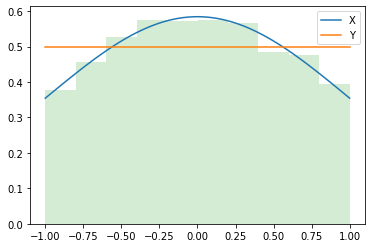

In [15]:
zs = rejection_sample_resample_failures(Y.rvs(10000), X.pdf, Y.pdf, m, X.rvs)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, X.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

I would say that looks pretty good. So that implies something is wrong with our algorithm in particular.

# Improved algorithm

The goal is to sample from $X$ with density $f$ where we already have samples $(y_0, y_1, ..., y_N) \sim Y$ with density $g$ where the $\text{support}(f) \subset \text{support}(g)$.

1. Do modified rejection sampling with proposal distribution Y.  
    a. $M = max \{ \frac{f(y)}{g(y)} : y \in (y_0, y_1, ..., y_N) \}$  
    b. $(u_0, u_1, ..., u_N) \sim U[0,1]$  
    c. For every $i \in 1, 2, ..., N$ if $u_i < \frac{f(y_i)}{M g(y_i)}$ keep the sample otherwise discard it.
2. Sample from X using alternative methods with new samples.

Sidenote:
For the change of support going from $Z$ to $z \subset Z$, we would need to show that $P(w) U[z]$ yields the same samples as sampling from $P(w)$ then throwing away the samples in $Z - z$. This is intuitively true.

### Last plot is already an example without a fixed data set size

$X \sim \mathcal{N}(0, 1) = f$ truncated to the interval $[-1,1]$.  
$Y \sim U[-1,1] = g$

### Finer details with a fixed data set.

When we have a limited number of $(y_0, y_1, ..., y_N)$ then we have this issue of determining $M$. We have to approximate it based off the samples we actually have.

In [16]:
np.random.seed(5)
y = Y.rvs(2)
m = np.max(X.pdf(y) / Y.pdf(y))
print(m)

if m < 1:
    m = 1
    print('m cannot be less than 1.')

1.0013491090458548


This shows that low numbers of samples are unlikely to approximate $M$ well. Perhaps that doesn't matter though because the rejection sampling will only occur for the samples in $(y_0, y_1, ..., y_N)$. Therefore, at the point we are going to sample, that M sets the bounding constant for $f(x) \leq M g(x)$?

I think this is a rather subtle point. If when we use an $\tilde{M} < M$, do we get the behavior we need in the regions of the graph where we have samples $(y_0, y_1, ..., y_N)$?

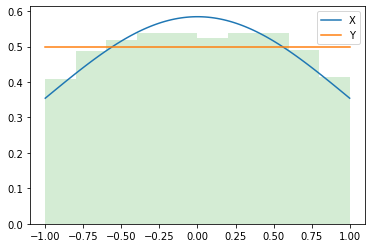

In [17]:
zs = rejection_sample(Y.rvs(100000), X.pdf, Y.pdf, m)

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)
ax.plot(x, X.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

Let's look at a case where the $X$ is much more highly peaked.

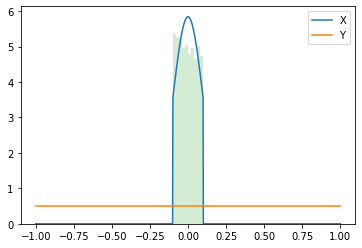

In [18]:
xx = truncnorm(a, b, loc=0, scale=0.1)
zs = rejection_sample(Y.rvs(100000), xx.pdf, Y.pdf, m)

fig, ax = plt.subplots()

x = np.linspace(a, b, 1000)
ax.plot(x, xx.pdf(x), label='X')
ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.legend()

fig.show()

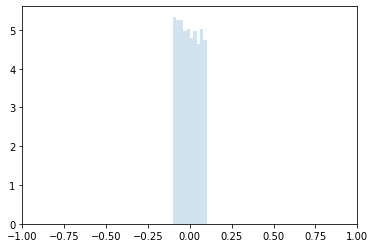

In [19]:
fig, ax = plt.subplots()

x = np.linspace(a, b, 1000)
# ax.plot(x, xx.pdf(x), label='X')
# ax.plot(x, Y.pdf(x), label='Y')
ax.hist(zs, density=True, alpha=0.2)
ax.set_xlim(-1, 1)

fig.show()

It looks like we might be able to get away with it visually. Essentially we are limited to sampling at ratios between f and g which are smaller than the maximum ratio?

This should be proven! If so, it's a big find.